<h1><center>CMPE 462 - Quiz 4&5 <br>Implementing a Regression Tree<br>Due: May 3, 2020, 23:59</center></h1>

## Task 1: Dataset 

In [1]:
import numpy as np
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
boston = load_boston()
X_y = np.column_stack([boston["data"], boston["target"]])
np.random.seed(1)
np.random.shuffle(X_y)
train, test = X_y[:400], X_y[400:] 

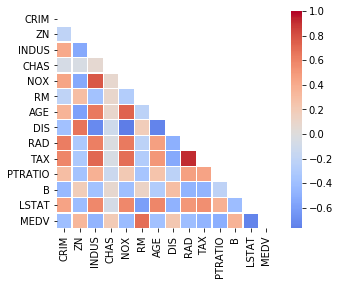

In [3]:
corr = np.corrcoef(train, rowvar=False)
names = np.hstack((boston.feature_names, ["MEDV"]))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, center=0, cmap="coolwarm", mask=mask, xticklabels=names, yticklabels=names, linewidths=.25, square=True)

> Strong positive correlations: 
- index of accessibility to radial highways `RAD` vs. full-value property-tax rate per \\$10,000 `TAX`
- proportion of non-retail business acres per town `INDUS` vs. nitric oxides concentration (parts per 10 million) `NOX`
- average number of rooms per dwelling `RM` vs. median value of owner-occupied homes in \\$1000's `MEDV`
- nitric oxides concentration (parts per 10 million) `NOX` vs. proportion of owner-occupied units built prior to 1940 `AGE`
- ...

> Strong negative correlations: 
- % lower status of the population `LSTAT` vs. median value of owner-occupied homes in \\$1000's `MEDV`
- proportion of owner-occupied units built prior to 1940 `AGE` vs. weighted distances to five Boston employment centres `DIS`
- nitric oxides concentration (parts per 10 million) `NOX` vs. weighted distances to five Boston employment centres `DIS`
- proportion of non-retail business acres per town `INDUS` vs. weighted distances to five Boston employment centres `DIS`
- ...

## Task 2: Regression Tree


In [4]:
def RSS(data, feature):
    data_sorted = data[data[:, feature].argsort()]
    threshold_list = []
    rss_list = []
    for i in range(data.shape[0]-1):
        threshold = data_sorted[i, feature]
        left = data_sorted[np.where(data_sorted[:, feature] <= threshold)]
        right = data_sorted[np.where(data_sorted[:, feature] > threshold)]
        rss = 0
        if left.shape[0] > 0:
            left_mean = np.mean(left[:, -1])
            rss += np.sum((left[:, -1] - left_mean)**2)
        if right.shape[0] > 0:
            right_mean = np.mean(right[:, -1])
            rss += np.sum((right[:, -1] - right_mean)**2)
        threshold_list.append(threshold)
        rss_list.append(rss)
    return rss_list, threshold_list

**Most correlated feature:** LSTAT (#12)

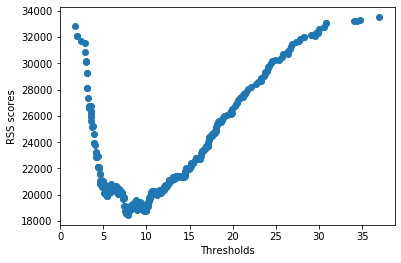

In [5]:
most = np.argmax(abs(corr[13, :13]))
r_list, t_list = RSS(train, most)
plt.scatter(t_list, r_list)
plt.xlabel("Thresholds")
plt.ylabel("RSS scores")
plt.show()

**Least correlated feature:** CHAS (#3)

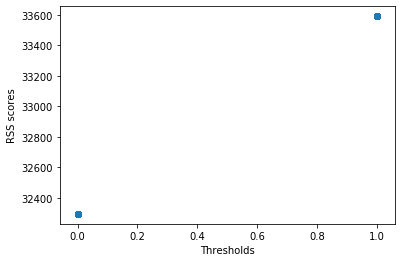

In [6]:
least = np.argmin(abs(corr[13]))
r_list, t_list = RSS(train, least)
plt.scatter(t_list, r_list)
plt.xlabel("Thresholds")
plt.ylabel("RSS scores")
plt.show()

> Since the least correlated feature is binary, there is only one possible division and it does not improve the impurity much. However, the most correlated feature almost halves the impurity with the optimal threshold.

In [7]:
class Node:
    def __init__(self, parent):
        self.parent = parent
        self.size = -1
        self.feature = -1
        self.temp_feature = -1
        self.threshold = -1
        self.rss = -1
        self.data = np.array([])
        self.left = None
        self.right = None

In [8]:
def regTree(data, node, maxDepth, boo, currentDepth=0):
    if maxDepth <= currentDepth or data.shape[0] <= 1:
        node.size = data.shape[0]
        node.data = data
    else:
        t_best = []
        r_best = []
        for i in range(data.shape[1]-1):
            r_list, t_list = RSS(data, i)
            r_best.append(np.min(r_list))
            t_best.append(t_list[np.argmin(r_list)])
        feature = np.argmin(r_best)
        node.temp_feature = feature
        node.threshold = t_best[feature]
        node.rss = r_best[feature]
        data_sorted = data[data[:, feature].argsort()]
        leftD = data_sorted[np.where(data_sorted[:, feature] <= node.threshold)]
        rightD = data_sorted[np.where(data_sorted[:, feature] > node.threshold)]
        leftD = np.delete(leftD, feature, 1)
        rightD = np.delete(rightD, feature, 1)
        for i in range(feature+currentDepth):
            if boo[i] == False and i <= feature:
                feature += 1
        boo[feature] = False
        boo_left = np.array(boo)
        boo_right = np.array(boo)
        node.size = data.shape[0]
        node.feature = feature
        node.right = Node(node)
        node.left = Node(node)
        regTree(leftD, node.left, maxDepth, boo_left, currentDepth+1)
        regTree(rightD, node.right, maxDepth, boo_right, currentDepth+1)

In [9]:
root_train = Node(None)
boo_train = np.ones_like(train[0], dtype=bool)
regTree(train, root_train, 3, boo_train)

In [10]:
def testTree(data, train_node, test_node):
    if train_node.feature == -1:
        test_node.size = data.shape[0]
        test_node.data = data
    else:
        feature = train_node.temp_feature
        test_node.feature = train_node.feature
        test_node.threshold = train_node.threshold
        test_node.size = train_node.size
        data_sorted = data[data[:, feature].argsort()]
        leftD = data_sorted[np.where(data_sorted[:, feature] <= test_node.threshold)]
        rightD = data_sorted[np.where(data_sorted[:, feature] > test_node.threshold)]
        left_mean = np.mean(leftD[:, -1]) if len(leftD) > 0 else 0
        left_sum = np.sum((leftD[:, -1] - left_mean)**2)
        right_mean = np.mean(rightD[:, -1]) if len(rightD) > 0 else 0
        right_sum = np.sum((rightD[:, -1] - right_mean)**2)
        test_node.rss = left_sum + right_sum
        leftD = np.delete(leftD, feature, 1)
        rightD = np.delete(rightD, feature, 1)
        test_node.left = Node(test_node)
        test_node.right = Node(test_node)
        testTree(leftD, train_node.left, test_node.left)
        testTree(rightD, train_node.right, test_node.right)

In [11]:
root_test = Node(None)
testTree(test, root_train, root_test)

**Training Tree:**

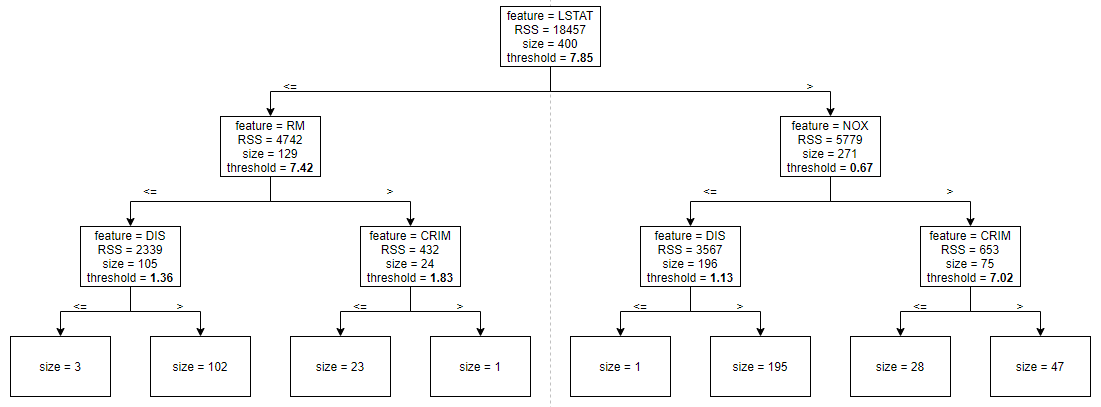

**Test Tree:**

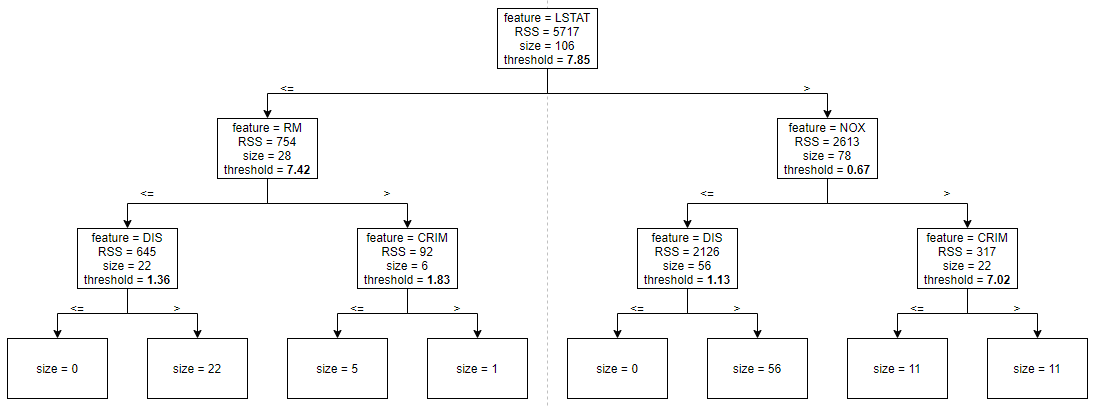

## Task 3: Evaluation

In [12]:
def prices(node, priceList, predList):
    if node.feature != -1:
        prices(node.left, priceList, predList)
        prices(node.right, priceList, predList)
    else:
        if node.data.shape[0] > 0:
            mean = np.mean(node.data[:, -1])
            for i in range(node.data.shape[0]):
                priceList.append(node.data[i, -1])
                predList.append(mean)

In [13]:
from random import seed
from random import randrange
seed(1)
split_data = []
data_copy = train
for i in range(5):
    fold_data = []
    while len(fold_data) < 400/5:
        index = randrange(len(data_copy))
        fold_data.append(data_copy[index])
        data_copy = np.delete(data_copy, index, 0)
    fold_data = np.array(fold_data)
    split_data.append(fold_data)
fivefold_data = []
for i in range(5):
    fivefold_data.append(np.vstack((split_data[(i+1)%5], split_data[(i+2)%5], split_data[(i+3)%5], split_data[(i+4)%5])))

In [14]:
from sklearn.metrics import r2_score
root_train_list = []
root_test_list = []
r2_train_list = []
r2_test_list = []
for i in range(5):
    train_data = fivefold_data[i]
    boo_train = np.ones_like(train_data[0], dtype=bool)
    test_data = split_data[i]
    for j in range(8):
        root_tr = Node(None)
        root_train_list.append(root_tr)
        regTree(train_data, root_train_list[8*i+j], j+3, boo_train)
        root_te = Node(None)
        root_test_list.append(root_te)
        testTree(test_data, root_train_list[8*i+j], root_test_list[8*i+j])
        price_train = []
        pred_train = []
        prices(root_train_list[8*i+j], price_train, pred_train)
        r2_train_list.append(r2_score(price_train, pred_train))
        price_test = []
        pred_test = []
        prices(root_test_list[8*i+j], price_test, pred_test)
        r2_test_list.append(r2_score(price_test, pred_test))

**$R^2$ scores for training data:**

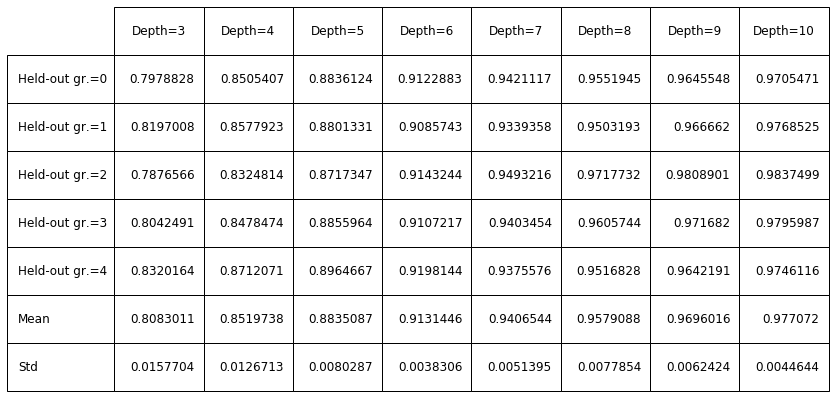

In [15]:
table = np.zeros((7, 8))
for i in range(7):
    for j in range(8):
        if i < 5:
            table[i][j] = r2_train_list[8*i+j]
        elif i == 5:
            table[i][j] = np.mean(table[0:5, j])
        else:
            table[i][j] = np.std(table[0:5, j])
plt.rcParams["figure.figsize"] = [6.4, 4.8]
fig, axs = plt.subplots(2,1)
collabel = ("Depth=3", "Depth=4", "Depth=5", "Depth=6",
            "Depth=7", "Depth=8", "Depth=9", "Depth=10")
rowlabel = ("Held-out gr.=0", "Held-out gr.=1", "Held-out gr.=2", "Held-out gr.=3", "Held-out gr.=4", "Mean", "Std")
axs[0].axis("off")
axs[1].axis("off")
the_table = axs[0].table(cellText=np.round(table, 7), rowLabels=rowlabel, colLabels=collabel, loc='center')
the_table.scale(2, 4)
the_table.set_fontsize(12)
plt.show()

**$R^2$ scores for test data:**

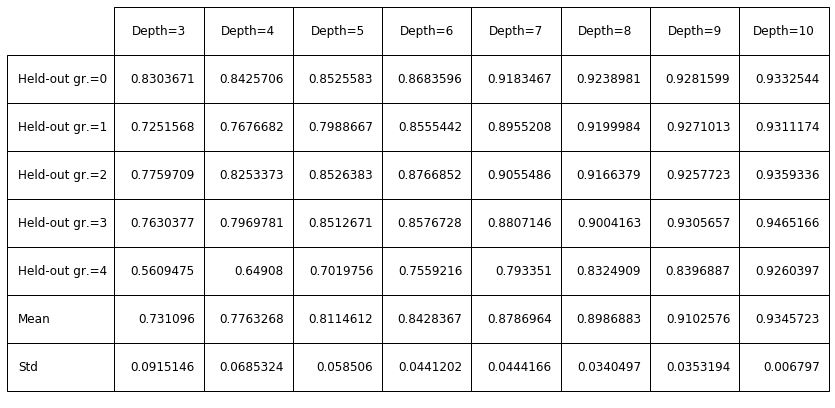

In [16]:
table = np.zeros((7, 8))
for i in range(7):
    for j in range(8):
        if i < 5:
            table[i][j] = r2_test_list[8*i+j]
        elif i == 5:
            table[i][j] = np.mean(table[0:5, j])
        else:
            table[i][j] = np.std(table[0:5, j])
plt.rcParams["figure.figsize"] = [6.4, 4.8]
fig, axs = plt.subplots(2,1)
collabel = ("Depth=3", "Depth=4", "Depth=5", "Depth=6",
            "Depth=7", "Depth=8", "Depth=9", "Depth=10")
rowlabel = ("Held-out gr.=0", "Held-out gr.=1", "Held-out gr.=2", "Held-out gr.=3", "Held-out gr.=4", "Mean", "Std")
axs[0].axis("off")
axs[1].axis("off")
the_table = axs[0].table(cellText=np.round(table, 7), rowLabels=rowlabel, colLabels=collabel, loc='center')
the_table.scale(2, 4)
the_table.set_fontsize(12)
plt.show()

**Best depth:** 10

In [17]:
root_final_train = Node(None)
boo_final = np.ones_like(train[0], dtype=bool)
regTree(train, root_final_train, 10, boo_final)
root_final_test = Node(None)
testTree(test, root_final_train, root_final_test)
price_final_train = []
pred_final_train = []
prices(root_final_train, price_final_train, pred_final_train)
print("R2 score for training set: \t" + str(r2_score(price_final_train, pred_final_train)))
price_final_test = []
pred_final_test = []
prices(root_final_test, price_final_test, pred_final_test)
print("R2 score for test set: \t\t" + str(r2_score(price_final_test, pred_final_test)))

R2 score for training set: 	0.963732582553543
R2 score for test set: 		0.8687146330602461
